# Temporal Difference Learning in Reinforcement Learning

This notebook demonstrates temporal difference (TD) learning methods, which combine the advantages of Monte Carlo methods and dynamic programming by learning from incomplete episodes through bootstrapping.

## Learning Objectives
By the end of this notebook, you will understand:
- How TD methods learn from incomplete episodes
- The difference between TD(0) prediction and TD control
- On-policy vs off-policy learning (SARSA vs Q-learning)
- The advantages of TD methods over Monte Carlo
- How to implement and compare different TD algorithms

## Key Concepts
- **TD(0) Prediction**: Learning value functions from one-step lookahead
- **SARSA**: On-policy TD control algorithm
- **Q-Learning**: Off-policy TD control algorithm
- **Bootstrapping**: Using current estimates to update other estimates
- **Temporal Differences**: Learning from differences between consecutive estimates

---

<a href="https://colab.research.google.com/github/xhxuciedu/CS175/blob/master/notebooks/temporal_difference_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Installation

**Note:** This notebook does not require a GPU, so make sure the runtime type is set to CPU to lower your Colab usage.

In [ ]:
%%capture
!pip install 'gymnasium[box2d]'
# !pip install matplotlib numpy

In [ ]:
# imports
import gymnasium as gym
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

# import the frozen lake gymnasium environment
name = 'FrozenLake-v1'
env = gym.make(name, is_slippery=False) # warning: setting slippery=True results in very complex environment dynamics where the optimal solution does not make sense to humans!

# Set up environment with proper seeding
observation, info = env.reset(seed=742)
env.action_space.seed(742)

# Add nS and nA attributes for compatibility with dynamic programming algorithms
env.nS = env.observation_space.n
env.nA = env.action_space.n

[742]

In [ ]:
# helper function to draw the frozen lake
def plot(V,policy,col_ramp=1,dpi=175,draw_vals=False):
    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams.update({'axes.edgecolor': (0.32,0.36,0.38)})
    plt.rcParams.update({'font.size': 4 if env.unwrapped.nrow == 8 else 7})
    plt.figure(figsize=(3,3))
    plt.imshow(1-V.reshape(env.unwrapped.nrow,env.unwrapped.ncol)**col_ramp, cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(env.unwrapped.ncol)-.5)
    ax.set_yticks(np.arange(env.unwrapped.nrow)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    for s in range(env.nS):
        x = s%env.unwrapped.nrow
        y = int(s/env.unwrapped.ncol)
        a = policy[s]
        gray = np.array((0.32,0.36,0.38))
        if env.unwrapped.desc.tolist()[y][x] == b'G':
            plt.text(x-0.45,y-0.3, 'goal', color=(0.75,0.22,0.17), fontname='Sans', weight='bold')
            continue
        if a[0] > 0.0: plt.arrow(x, y, float(a[0])*-.84, 0.0, color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # left
        if a[1] > 0.0: plt.arrow(x, y, 0.0, float(a[1])*.84,  color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # down
        if a[2] > 0.0: plt.arrow(x, y, float(a[2])*.84, 0.0,  color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # right
        if a[3] > 0.0: plt.arrow(x, y, 0.0, float(a[3])*-.84, color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # up
        if env.unwrapped.desc.tolist()[y][x] == b'F': plt.text(x-0.45,y-0.3, 'ice', color=(gray*V[s]), fontname='Sans')
        if env.unwrapped.desc.tolist()[y][x] == b'S': plt.text(x-0.45,y-0.3, 'start',color=(0.21,0.51,0.48), fontname='Sans', weight='bold')
        if draw_vals and V[s]>0:
            vstr = '{0:.1e}'.format(V[s]) if env.unwrapped.nrow == 8 else '{0:.6f}'.format(V[s])
            plt.text(x-0.45,y+0.45, vstr, color=(gray*V[s]), fontname='Sans')
    plt.grid(color=(0.42,0.46,0.48), linestyle=':')
    ax.set_axisbelow(True)
    ax.tick_params(color=(0.42,0.46,0.48),which='both',top='off',left='off',right='off',bottom='off')
    plt.show()

# helper function to show policy
def pi_star_from_Q(Q):
    terminated = False
    truncated = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset() # start in top-left, = 0
    while not (terminated or truncated):
        action = np.argmax(Q[state, :])
        pi_star[state,action] = 1
        state, reward, terminated, truncated, _ = env.step(action)
    return pi_star

## Understanding Temporal Difference Learning

Temporal Difference (TD) methods combine the advantages of Monte Carlo methods and dynamic programming:

- **Like Monte Carlo**: Learn directly from experience without a model
- **Like Dynamic Programming**: Update estimates based on other learned estimates (bootstrapping)
- **Key Advantage**: Can learn from incomplete episodes, making them more efficient

### TD(0) Update Rule:
$$V(S_t) \leftarrow V(S_t) + \alpha[R_{t+1} + \gamma V(S_{t+1}) - V(S_t)]$$

The term $R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$ is called the **TD error**.

## TD(0) Prediction

Let's start with TD(0) prediction, which learns value functions from incomplete episodes.

In [ ]:
num_episodes = 10000
alpha = 0.2
gamma = 1.0
V = np.zeros([env.observation_space.n])

for episode in range(1,num_episodes+1):
    s, info = env.reset()
    while (True):
        a = np.ones(env.action_space.n, dtype=float) / env.action_space.n # random policy
        a = np.random.choice(len(a), p=a)
        next_s, reward, terminated, truncated, _ = env.step(a)
        V[s] += alpha * (reward + gamma * V[next_s] - V[s])
        if terminated or truncated: break
        s = next_s

...this is just prediction, it doesn't solve the control problem - let's plot the policy learned from all this random walking

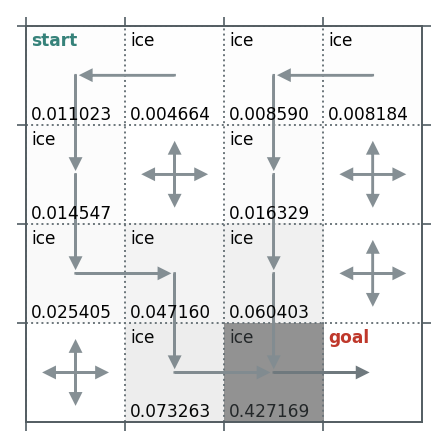

In [ ]:
# helper code to plot the policy greedily obtained from TD(0) - ignore this!
policy = np.zeros([env.nS, env.nA]) / env.nA
for s in range(env.nS):
    q = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.unwrapped.P[s][a]:
            q[a] += prob * (reward + gamma * V[next_state])
    best_a = np.argwhere(q==np.max(q)).flatten()
    policy[s] = np.sum([np.eye(env.nA)[i] for i in best_a], axis=0)/len(best_a)
plot(V,policy,1.0,draw_vals=True)

...the policy is note too bad after one greedy policy step, but it's not perfect - we really need to do control

**On-Policy SARSA TD control** - warning! sometimes this doesn't converge! run it a few times...

In [ ]:
def random_epsilon_greedy_policy(Q, epsilon, state, nA):
    A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[state])
    A[best_action] += (1.0 - epsilon)
    return A

In [ ]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
num_episodes = 10000
gamma = 1.0
epsilon = 0.4
alpha = 0.2
stats_rewards = defaultdict(float)
stats_lengths = defaultdict(float)

for episode in range(1,num_episodes+1):
    s, info = env.reset()
    p_a = random_epsilon_greedy_policy(Q, epsilon, s, env.action_space.n)
    a = np.random.choice(np.arange(len(p_a)), p=p_a)
    for t in itertools.count():
        next_s, reward, terminated, truncated, _ = env.step(a)
        p_next_a = random_epsilon_greedy_policy(Q,epsilon, next_s, env.action_space.n)
        next_a   = np.random.choice(np.arange(len(p_next_a)), p=p_next_a)
        Q[s][a] += alpha * (reward + gamma*Q[next_s][next_a] - Q[s][a])

        stats_rewards[episode] += reward
        stats_lengths[episode] = t
        if terminated or truncated: break
        s = next_s
        a = next_a

    if episode % 1000 == 0 and episode is not 0:
        print(f"episode: {episode}/{num_episodes}")

print(f"episode: {episode}/{num_episodes}")

env.close()

episode: 1000/10000
episode: 2000/10000
episode: 3000/10000
episode: 4000/10000
episode: 5000/10000
episode: 6000/10000
episode: 7000/10000
episode: 8000/10000
episode: 9000/10000
episode: 10000/10000
episode: 10000/10000


Text(0, 0.5, 'reward (smoothed)')

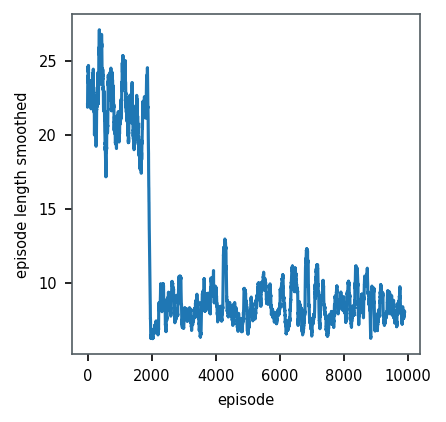

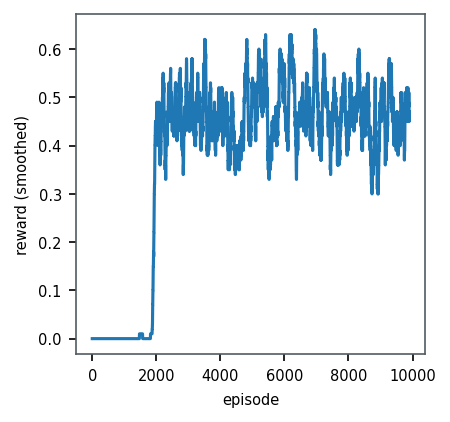

In [ ]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

smoothed_lengths = moving_average(np.array(list(stats_lengths.values())))

plt.rcParams['figure.dpi'] = 150

plt.figure(1, figsize=(3,3))
plt.plot(smoothed_lengths)
plt.xlabel('episode')
plt.ylabel('episode length smoothed')

smoothed_rewards = moving_average(np.array(list(stats_rewards.values())))
plt.figure(2, figsize=(3,3))
plt.plot(smoothed_rewards)
plt.xlabel('episode')
plt.ylabel('reward (smoothed)')

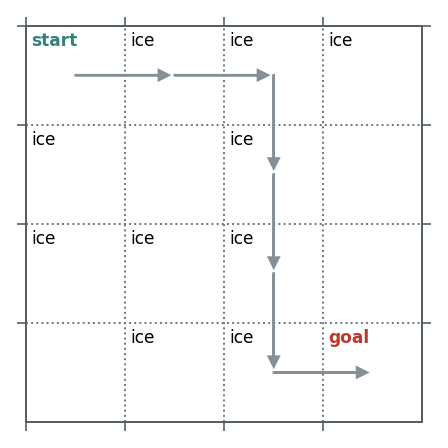

In [ ]:
plot(np.zeros_like(Q[:,0]), pi_star_from_Q(Q))

**Off-policy Q-learning TD Control** - warning! sometimes this doesn't converge! run it a few times...

In [ ]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
num_episodes = 10000
gamma = 1.0
epsilon = 0.4
alpha = 0.2
stats_rewards = defaultdict(float)
stats_lengths = defaultdict(float)

for episode in range(1,num_episodes+1):
    s, info = env.reset()
    for t in itertools.count():
        p_a = random_epsilon_greedy_policy(Q, epsilon, s, env.action_space.n)
        a   = np.random.choice(np.arange(len(p_a)), p=p_a)
        next_s, reward, terminated, truncated, _ = env.step(a)
        Q[s][a] += alpha * (reward + gamma*np.max(Q[next_s][:]) - Q[s][a])

        stats_rewards[episode] += reward
        stats_lengths[episode] = t
        if terminated or truncated: break
        s = next_s

    if episode % 1000 == 0 and episode is not 0:
        print(f"episode: {episode}/{num_episodes}")

print(f"episode: {episode}/{num_episodes}")

env.close()

episode: 1000/10000
episode: 2000/10000
episode: 3000/10000
episode: 4000/10000
episode: 5000/10000
episode: 6000/10000
episode: 7000/10000
episode: 8000/10000
episode: 9000/10000
episode: 10000/10000
episode: 10000/10000


Text(0, 0.5, 'reward (smoothed)')

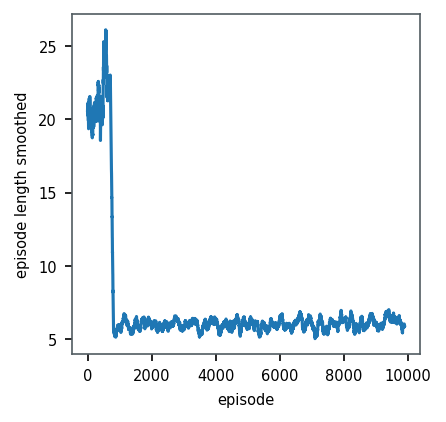

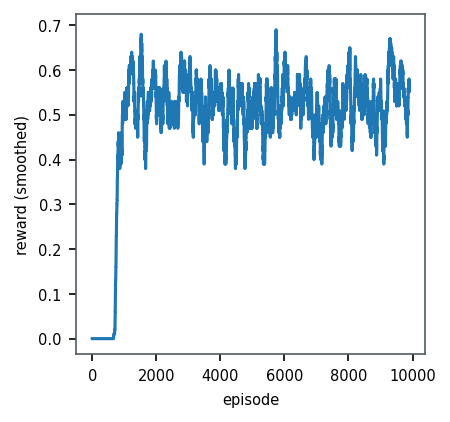

In [ ]:
# plot the results
smoothed_lengths = moving_average(np.array(list(stats_lengths.values())))

plt.rcParams['figure.dpi'] = 150

plt.figure(1, figsize=(3,3))
plt.plot(smoothed_lengths)
plt.xlabel('episode')
plt.ylabel('episode length smoothed')

smoothed_rewards = moving_average(np.array(list(stats_rewards.values())))
plt.figure(2, figsize=(3,3))
plt.plot(smoothed_rewards)
plt.xlabel('episode')
plt.ylabel('reward (smoothed)')